<a href="https://colab.research.google.com/github/vikasg964/Stock_price_forcasting/blob/main/Time_Series_forcasting_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

%matplotlib inline

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import io
import requests
import shutil
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn import metrics

Helper functions

In [ ]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

    # Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [ ]:
df_stock = pd.read_csv('/content/sample_data/CSC215_P2_Stock_Price.csv')

In [ ]:

df_stock.shape

(4392, 7)

In [ ]:
df_stock.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


Dropping missing values

In [ ]:

# storing the original dataset in a different dataframe before dropping the columns 
df_stock_new = df_stock
df_stock_new.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


In [ ]:
# dropping the columns Date and Adj_Close
df_stock_new=df_stock_new.drop(['Date', 'Adj_Close'], axis=1)
df_stock_new.head()
#df_stock_new.['y'] = df_stock_new.['Close']

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [ ]:
df_stock_new.shape

(4392, 5)

In [ ]:
df_stock.shape

(4392, 7)

Removing null values

In [ ]:
#Calling sum() of the DataFrame returned by isnull() will give a series containing data about count of NaN in each column
df_stock_new.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [ ]:
# creating a copy of the column, Close
df_stock_new['y'] = df_stock_new['Close']

In [ ]:
df_stock_new.head()

,Open,High,Low,Close,Volume,y
0,3.812500,4.156250,3.812500,4.125000,3675600,4.125000
1,4.125000,4.125000,4.000000,4.015625,1077600,4.015625
2,4.000000,4.031250,3.953125,4.000000,437200,4.000000
3,4.000000,4.000000,3.843750,3.843750,1883600,3.843750
4,3.734375,3.734375,3.390625,3.390625,7931600,3.390625


Normalizing the columns

In [ ]:
#Normalizing except  last column y
for column in df_stock_new.columns:
  if  column != 'y':
    encode_numeric_zscore(df_stock_new, column)

#print first  5 rows in new csv file to check for normalizing
print(df_newstock.head)

<bound method NDFrame.head of            Date        Open        High  ...       Close   Adj_Close   Volume
0     2000/3/27    3.812500    4.156250  ...    4.125000    4.125000  3675600
1     2000/3/28    4.125000    4.125000  ...    4.015625    4.015625  1077600
2     2000/3/29    4.000000    4.031250  ...    4.000000    4.000000   437200
3     2000/3/30    4.000000    4.000000  ...    3.843750    3.843750  1883600
4     2000/3/31    3.734375    3.734375  ...    3.390625    3.390625  7931600
...         ...         ...         ...  ...         ...         ...      ...
4387   2017/9/1  113.790001  114.099998  ...  113.309998  113.309998   950000
4388   2017/9/5  112.519997  113.529999  ...  111.870003  111.870003  1805200
4389   2017/9/6  112.029999  112.489998  ...  112.230003  112.230003  2136700
4390   2017/9/7  112.459999  112.900002  ...  112.339996  112.339996  1251600
4391   2017/9/8  112.300003  114.790001  ...  113.190002  113.190002  1611700

[4392 rows x 7 columns]>


In [ ]:
# Set all column other than y as input or 'x'
x = df_stock_new.iloc[:,df_stock_new.columns != 'y']
x = np.array(x, dtype=np.float32)

# Set the y column as output or 'y'
y = np.array(df_stock_new['y'].values, dtype=np.float32)
print(x.shape)
print(y.shape)

(4392, 5)
(4392,)


In [ ]:
import numpy as np

def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [ ]:
SEQUENCE_SIZE = 7
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)
x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of x_lstseq: {}".format(x_lstseq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))

Shape of x_lstseq: (4385, 7, 1, 5)
Shape of y_lstseq: (4385,)


In [ ]:
x_seq_4d = x_lstseq.reshape(4385,1,7,5)

Split data into 70/30

In [ ]:
##Split train and test date 70/30
x_train, x_test, y_train, y_test = train_test_split(x_lstseq, y_lstseq, test_size=0.3, random_state=0)

print("Shape of x_train :{}".format(x_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))

print("Shape of y_train :{}".format(y_train.shape))
print("Shape of y_test  :{}".format(y_test.shape))

type(x_test),type(y_test),type(x_train),type(y_train)

Shape of x_train :(3069, 7, 1, 5)
Shape of x_test  :(1316, 7, 1, 5)
Shape of y_train :(3069,)
Shape of y_test  :(1316,)


(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

Neural Networks




Model trained for "adam" optimizer and "relu" activation function : 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                28736     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745
N

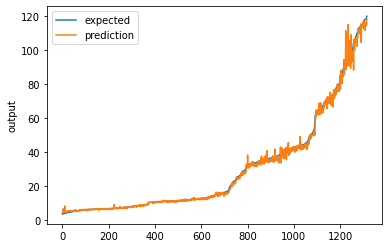




Model trained for "adam" optimizer and "sigmoid" activation function : 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                28736     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 31,745
Trainable params: 31,74

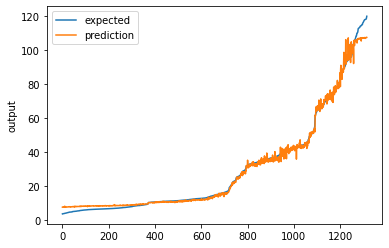




Model trained for "adam" optimizer and "tanh" activation function : 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                28736     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745


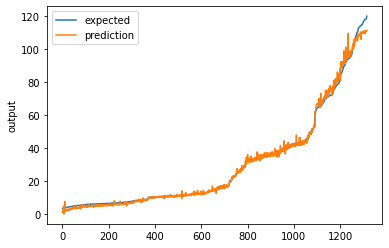




Model trained for "sgd" optimizer and "relu" activation function : 

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                28736     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745
N

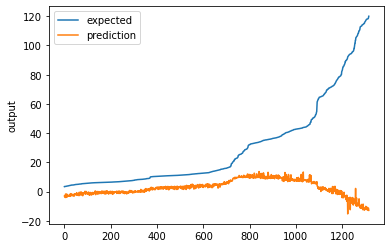




Model trained for "sgd" optimizer and "sigmoid" activation function : 

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                28736     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 31,745
Trainable params: 31,74

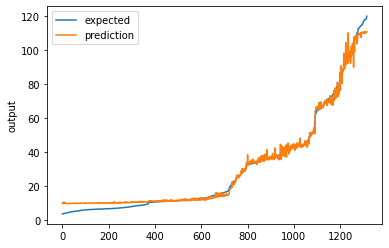




Model trained for "sgd" optimizer and "tanh" activation function : 

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                28736     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745
N

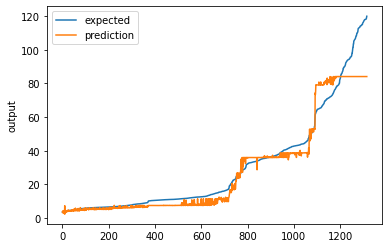

In [ ]:
from sklearn import metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


optimizers = ['adam','sgd']
activation_functions = ['relu','sigmoid','tanh']

for opt in optimizers:
    for act in activation_functions:
        
        print("\n\n\nModel trained for \"{}\" optimizer and \"{}\" activation function : \n".format(opt,act))
        
        model = Sequential()
        model.add(Conv2D(64, kernel_size=(3,3), strides=(1, 1), padding='same',activation=act,input_shape=(1,7,5)))
        model.add(MaxPooling2D(pool_size=(1,1), strides=None))
        model.add(Flatten())
        model.add(Dense(64, activation=act))
        model.add(Dropout(0.5))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=opt)
        model.summary()
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)
        
        model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
        model.load_weights('best_weights.hdf5')
        
        pred = model.predict(x_test)
        
        # Measure MSE error.  
        mse = metrics.mean_squared_error(pred,y_test)
        print("\n\nFinal score (MSE): {}".format(mse))
        
        # Measure RMSE error.  RMSE is common for regression.
        rmse = np.sqrt(metrics.mean_squared_error(pred,y_test))
        print("Final score (RMSE): {}".format(rmse))
        
        chart_regression(pred.flatten(),y_test,sort=True)